<a href="https://colab.research.google.com/github/moey920/NLP/blob/master/%EC%98%81%EC%88%98%EC%A6%9D_seq2seq_attention(ver_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Number of samples: 7555
Number of unique input tokens: 903
Number of unique output tokens: 820
Max sequence length for inputs: 79
Max sequence length for outputs: 68
Load weights?n
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 79, 903)      0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 68, 820)      0                                            
__________________________________________________________________________________________________
gru_3 (GRU)                     [(None, 79, 1024), ( 5922816     input_3[0][0]                    
__________________________________________________________________________________________________
gru_4 (GRU

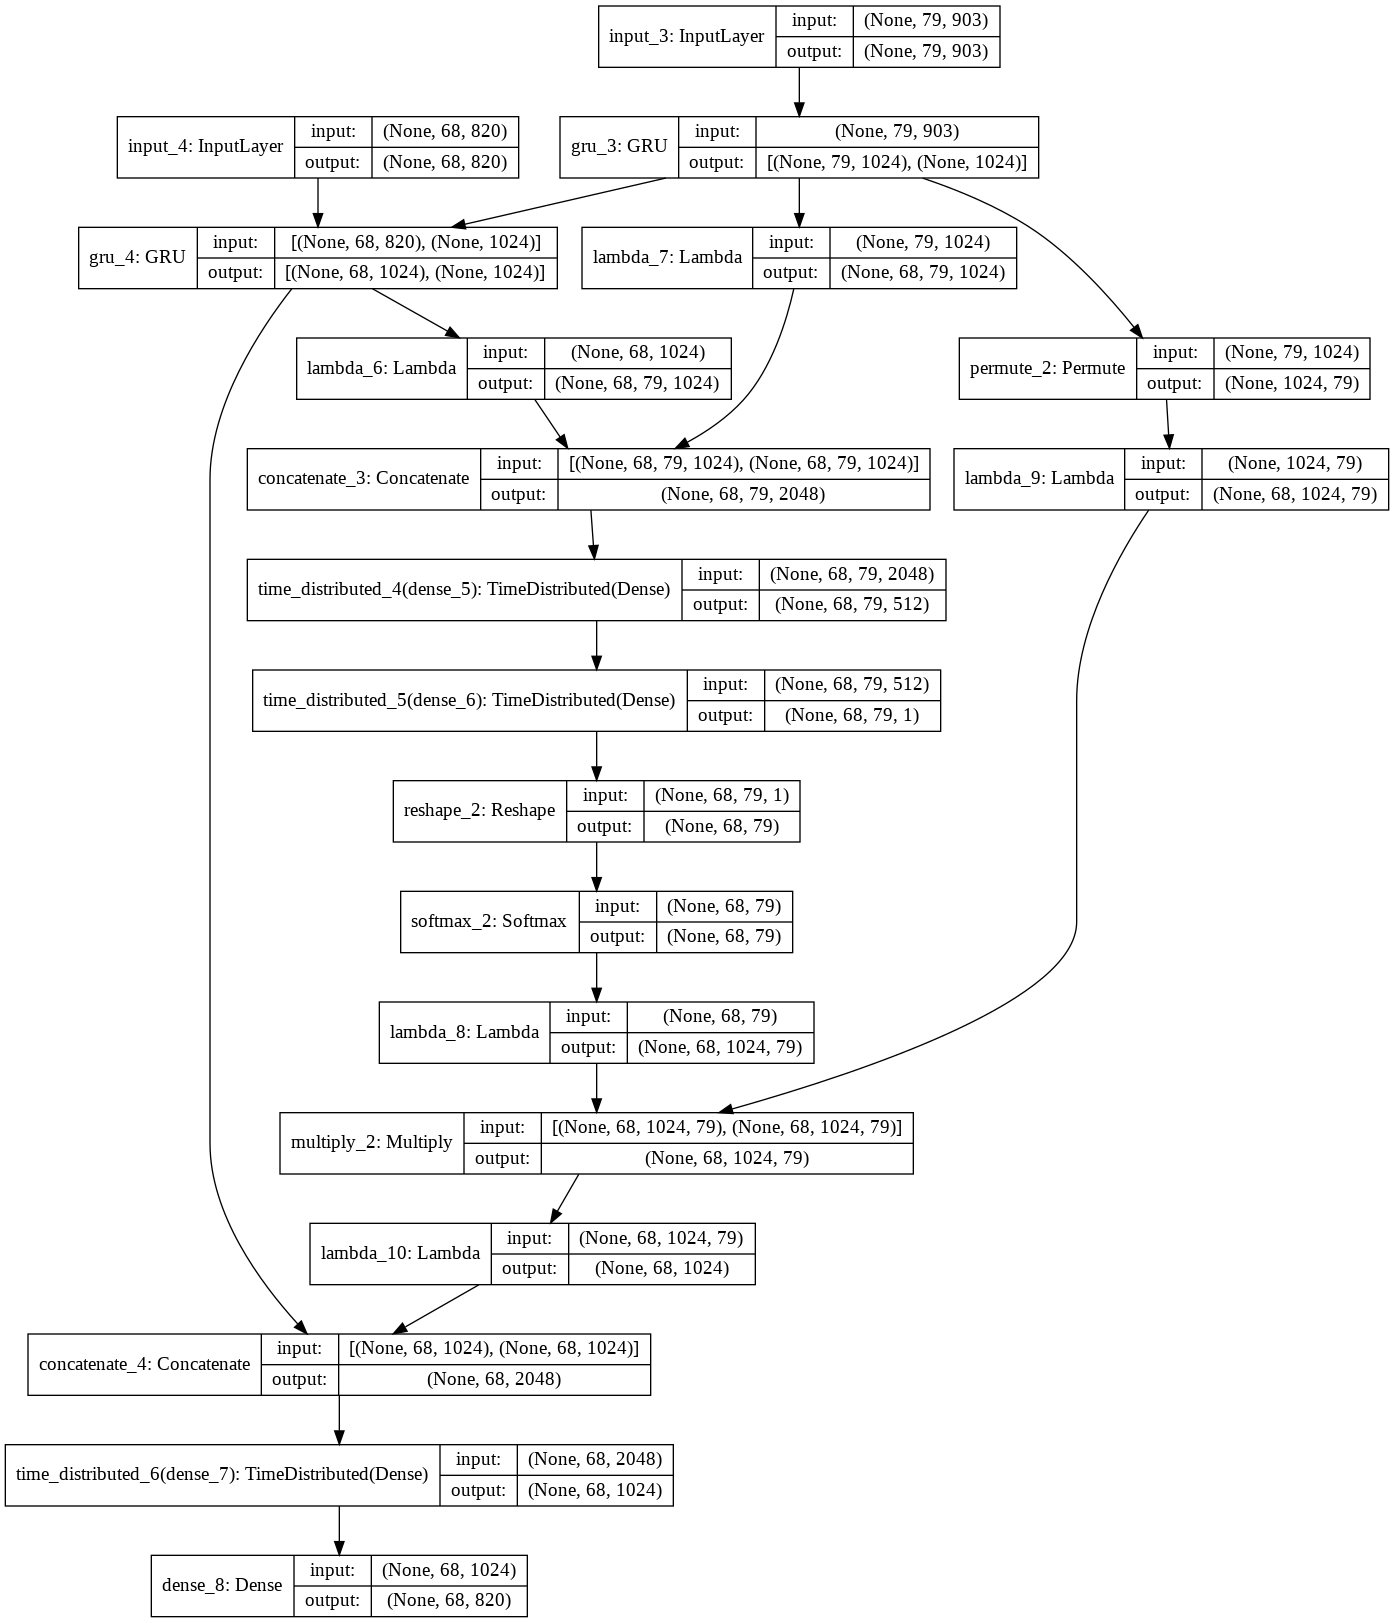

In [2]:
from keras import layers, models
from keras import datasets 
from keras import backend as K 
from keras.utils import plot_model 
import matplotlib 
from matplotlib import ticker 
import matplotlib.pyplot as plt 
import numpy as np 
#from IPython.display import Image, display 
'''
import tensorflow.backend as tf
from tensorflow.core.protobuf import rewriter_config_pb2
from keras.backend import set_session
tf.keras.backend.clear_session()  # For easy reset of notebook state.

config_proto = tf.ConfigProto()
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
session = tf.Session(config=config_proto)
set_session(session)
'''

# 학습 정보 
batch_size = 32
epochs = 200
latent_dim = 1024
num_samples = 10000
data_path = '/content/drive/My Drive/캐시카우_노하람인턴_공유폴더/seq2seq/transformer_dataset.txt' #제작한 데이터 경로를 설정해주세요, 텍스트 파일이 UTF-8로 인코딩 되어있지 않으면 오류가 발생합니다.

# 문장 벡터화 
input_texts = [] 
target_texts = [] 
input_characters = set() 
target_characters = set() 


with open(data_path, 'r', encoding='utf-8') as f:       # data_path를 읽기모드로, utf-8로 인코딩하여 f라는 이름으로 로드한다
    lines = f.read().split('\n')                        # f를 \n을 기준으로 나누어 한 줄씩 읽어 lines 변수에 저장한다.
for line in lines[: min(num_samples, len(lines) - 1)]:  # line을 lines까지, 처음부터 lines의 개수
                                                        # 훈련 샘플의 개수(10000)개와 실제 로드한 데이터의 개수(len(lines)-1)을 비교하여 최고값을 리턴하고, 처음부터 최소값까지 반복한다.
                                                        # 내장함수 min() : 반복가능한 객체의 가장 작은 요소 값을 리턴
    input_text, target_text, _ = line.split('\t')       # input_text(인풋), target_text(아웃풋), _(인덱스)는 한 문장으로 구성되어 있어 각각의 요소를 \t(TAB)으로 구분한다.
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.    "\t"문자를 시작 문자로, "\n"문자를 종료 문자로 사용.
    target_text = '\t' + target_text + '\n'             # targer_text는 앞에 '\t', 뒤에 '\n'을 붙인다.
    input_texts.append(input_text)                      # input_texts 라는 빈 리스트에 input_text를 하나씩 집어넣는다. 
    target_texts.append(target_text)                    # target_texts 라는 빈 리스트에 target_text를 하나씩 집어넣는다. 
    for char in input_text:                             # char(character) 변수를 input_text의 처음부터 끝까지
        if char not in input_characters:                # 만약 char가 input_characters(집합)에 없다면  
            input_characters.add(char)                  # 집합은 문자열을 문자단위로 나누어 원소로 가지고, 중복을 제거한다. 따라서 문장이였던 char에서 중복을 제거한 문자들이 input_characters(집합)에 추가된다.
    for char in target_text:                            # char(character) 변수를 input_text의 처음부터 끝까지
        if char not in target_characters:               # 만약 char가 input_characters(집합)에 없다면  
            target_characters.add(char)                 # 집합에 char변수를 추가한다.

# 학습 데이터 개수 
num_samples = len(input_texts) 
input_characters = sorted(list(input_characters)) 
target_characters = sorted(list(target_characters)) 
num_encoder_tokens = len(input_characters) 
num_decoder_tokens = len(target_characters) 
max_encoder_seq_length = max([len(txt) for txt in input_texts]) 
max_decoder_seq_length = max([len(txt) for txt in target_texts]) 
print('Number of samples:', num_samples) 
print('Number of unique input tokens:', num_encoder_tokens) 
print('Number of unique output tokens:', num_decoder_tokens) 
print('Max sequence length for inputs:', max_encoder_seq_length) 
print('Max sequence length for outputs:', max_decoder_seq_length) 

# 문자 -> 숫자 변환용 사전 
input_token_index = dict( [(char, i) for i, char in enumerate(input_characters)]) 
target_token_index = dict( [(char, i) for i, char in enumerate(target_characters)]) 

# 학습에 사용할 데이터를 담을 3차원 배열 
encoder_input_data = np.zeros( (num_samples, max_encoder_seq_length, num_encoder_tokens), dtype='float32') 
decoder_input_data = np.zeros( (num_samples, max_decoder_seq_length, num_decoder_tokens), dtype='float32') 
decoder_target_data = np.zeros( (num_samples, max_decoder_seq_length, num_decoder_tokens), dtype='float32') 

# 문장을 문자 단위로 원 핫 인코딩하면서 학습용 데이터를 만듬 
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)): 
    for t, char in enumerate(input_text): 
        encoder_input_data[i, t, input_token_index[char]] = 1. 
    for t, char in enumerate(target_text): 
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0 :
            decoder_target_data[i, t - 1, target_token_index[char]] = 1. 
            
# 숫자 -> 문자 변환용 사전 
reverse_input_char_index = dict( (i, char) for char, i in input_token_index.items()) 
reverse_target_char_index = dict( (i, char) for char, i in target_token_index.items()) 

def RepeatVectorLayer(rep, axis): 
    return layers.Lambda(lambda x: K.repeat_elements(K.expand_dims(x, axis), rep, axis), 
                         lambda x: tuple((x[0],) + x[1:axis] + (rep,) + x[axis:]))
    
 # 인코더 생성
encoder_inputs = layers.Input(shape=(max_encoder_seq_length, num_encoder_tokens))
encoder = layers.GRU(latent_dim, return_sequences=True, return_state=True) 
encoder_outputs, state_h = encoder(encoder_inputs) 
 
 # 디코더 생성. 
decoder_inputs = layers.Input(shape=(max_decoder_seq_length, num_decoder_tokens)) 
decoder = layers.GRU(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs, _ = decoder(decoder_inputs, initial_state=state_h) 
 
 # 어텐션 매커니즘. 
repeat_d_layer = RepeatVectorLayer(max_encoder_seq_length, 2) 
repeat_d = repeat_d_layer(decoder_outputs) 
 
repeat_e_layer = RepeatVectorLayer(max_decoder_seq_length, 1) 
repeat_e = repeat_e_layer(encoder_outputs) 
 
concat_for_score_layer = layers.Concatenate(axis=-1) 
concat_for_score = concat_for_score_layer([repeat_d, repeat_e]) 
 
dense1_t_score_layer = layers.Dense(latent_dim // 2, activation='tanh') 
dense1_score_layer = layers.TimeDistributed(dense1_t_score_layer) 
dense1_score = dense1_score_layer(concat_for_score) 
dense2_t_score_layer = layers.Dense(1) 
dense2_score_layer = layers.TimeDistributed(dense2_t_score_layer) 
dense2_score = dense2_score_layer(dense1_score) 
dense2_score = layers.Reshape((max_decoder_seq_length, max_encoder_seq_length))(dense2_score) 
 
softmax_score_layer = layers.Softmax(axis=-1) 
softmax_score = softmax_score_layer(dense2_score) 
 
repeat_score_layer = RepeatVectorLayer(latent_dim, 2) 
repeat_score = repeat_score_layer(softmax_score) 
 
permute_e = layers.Permute((2, 1))(encoder_outputs) 
repeat_e_layer = RepeatVectorLayer(max_decoder_seq_length, 1) 
repeat_e = repeat_e_layer(permute_e) 
 
attended_mat_layer = layers.Multiply() 
attended_mat = attended_mat_layer([repeat_score, repeat_e]) 
 
context_layer = layers.Lambda(lambda x: K.sum(x, axis=-1), 
                              lambda x: tuple(x[:-1])) 
context = context_layer(attended_mat) 
 
concat_context_layer = layers.Concatenate(axis=-1) 
concat_context = concat_context_layer([context, decoder_outputs]) 

attention_dense_output_layer = layers.Dense(latent_dim, activation='tanh') 
attention_output_layer = layers.TimeDistributed(attention_dense_output_layer) 
attention_output = attention_output_layer(concat_context) 

decoder_dense = layers.Dense(num_decoder_tokens, activation='softmax') 
decoder_outputs = decoder_dense(attention_output) 

# 모델 생성 
model = models.Model([encoder_inputs, decoder_inputs], decoder_outputs) 

# 콜백함수 정의
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=2, mode='min') # 조기종료 콜백함수 정의

choice = input("Load weights?") 
if choice == 'y' or choice == 'Y': 
   model.load_weights('att_seq2seq_weights.h5') 
   
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc']) 
model.summary() 
plot_model(model, show_shapes=True, to_file='model.png') 
#display(Image(filename='model.png')) 

Train?y
Epoch 00021: early stopping


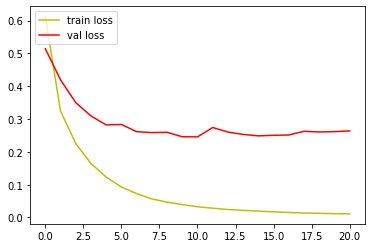

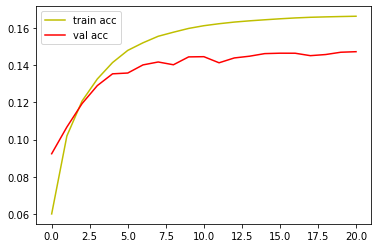

In [3]:
choice = input("Train?") 
if choice == 'y' or choice == 'Y': 
    # 학습 
    history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data, 
                        batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=0, callbacks=[early_stopping]) 
    model.save_weights('att_seq2seq_weights.h5') 
    
    # 손실 그래프 
    plt.plot(history.history['loss'], 'y', label='train loss') 
    plt.plot(history.history['val_loss'], 'r', label='val loss') 
    plt.legend(loc='upper left') 
    plt.show() 
    
    # 정확도 그래프 
    plt.plot(history.history['acc'], 'y', label='train acc') 
    plt.plot(history.history['val_acc'], 'r', label='val acc') 
    plt.legend(loc='upper left') 
    plt.show() 

['=', '=', '=', '=', '=', '=', '=', '=', '=', '=', '=', '=', '=', '=', '=', '=', '=', '=', '=', '=', '=', '=', '=', '=', '=', '=', '=', '=', '=', '=', '=', '=', '\n']


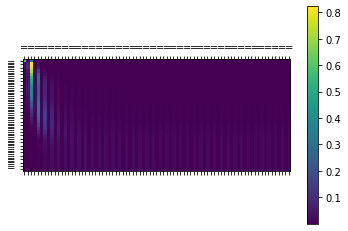

"ori" -> "hand"
"CJ올리브영( ㈜ 이선신보집" -> "CJ올리브영㈜ 인천신포점"
"인전광역시 중구 개항로 - " -> "인천광역시 중구 개항로 -"
"김희선 TEL :" -> "김희선 TEL:"
"POS : 김희선" -> "POS: 김희선"
"고객센터 : www .oliveyoung . co . kr" -> "고객센터 : www.oliveyoung.co.kr"
"교환/ 환불은 결제일로부터 일 (월 일) 내" -> "교환/환불은 결제일로부터 일(월 일)내"
"판매가능한 정상품( 미개봉) 에 한해 결제했던" -> "판매가능한 정상품(미개봉)에 한해 결제했던"
"수단과 구매영수증 지참 후 매장 방문시 가능" -> "단과 구매영수증 지참 후 매장 방문시 가능"
"* 단 환불 결제수단 변경은 구매매장에서만" -> "* 단 환불/결제수단 변경은 구매매장에서만"
"가능 의한 환불은" -> "가능"
"부분교환 영수증/ 선물교환증에 지참" -> "****영 영수증/선물교환증에 의한 환불은"
"가하며 부분교회 영수증/ 선물교환증을 상품으로" -> "불가하며 부분교환 영수증/선물교환증을 지참"
"하여 매장 방문 시 해당금액 이상의" -> "하여 매장 방문 시 해당금액 이상의 상품으로"
"교환만 가능" -> "교환만 가능"
"* 증정품 미지참 시 교환/ 환블 불가" -> "* 증정품 미지참 시 교환/환불 불가"
"* 클리어런스 상품은 교환/ 환불 불가" -> "*클리어런스 상품은 교환/환불 불가"
"[ 재 발 행 영 수 증 ]" -> "[재 발 행 영 수 증]"
" 카드전표( 고객용 )" -> "카드전표 (고객용)"
"SEEEEEEEEE 금액" -> "=================================="
" 상품명 단가 수량" -> "상품명 단가 수량 금액"
" ) KAI 미니눈썹칼(입) " -> ") KAI미니눈니눈칼(입)"
"면세품목" -> "면세품목"
"*상품 표시품목 지표로 ::: 부가세 제휴 제휴 중복할인 중독 불가" -> "상품앞 @표시품목 : 

In [5]:
 # 어텐션 검증 
test_data_num = 0 
test_max_len = 0 
for i, s in enumerate(input_texts): 
    if len(s) > test_max_len: 
        test_max_len = len(s) 
        test_data_num = i 
        
test_enc_input = encoder_input_data[test_data_num].reshape( (1, max_encoder_seq_length, num_encoder_tokens)) 
test_dec_input = decoder_input_data[test_data_num].reshape( (1, max_decoder_seq_length, num_decoder_tokens)) 

attention_layer = softmax_score_layer 
func = K.function([encoder_inputs, decoder_inputs] + [K.learning_phase()], [attention_layer.output]) 
score_values = func([test_enc_input, test_dec_input, 1])[0] 
score_values = score_values.reshape((max_decoder_seq_length, max_encoder_seq_length)) 

score_values = score_values[:len(target_texts[test_data_num])-1, :len(input_texts[test_data_num])] 

fig = plt.figure() 
ax = fig.add_subplot(111) 
cax = ax.matshow(score_values, interpolation='nearest') 
fig.colorbar(cax) 

test_enc_names = [] 
for vec in test_enc_input[0]: 
    sampled_token_index = np.argmax(vec) 
    sampled_char = reverse_input_char_index[sampled_token_index] 
    test_enc_names.append(sampled_char) 
test_dec_names = [] 
for vec in test_dec_input[0]: 
    sampled_token_index = np.argmax(vec) 
    sampled_char = reverse_target_char_index[sampled_token_index] 
    test_dec_names.append(sampled_char) 
    
print(test_dec_names[1:len(target_texts[test_data_num])]) 
ax.xaxis.set_major_locator(ticker.MultipleLocator(1)) 
ax.yaxis.set_major_locator(ticker.MultipleLocator(1)) 
ax.set_yticklabels(['']+test_dec_names[1:-1] + ['<END>'])
ax.set_xticklabels(['']+test_enc_names)

plt.show() 

# 추론(테스트) 
# 추론 모델 생성 
encoder_model = models.Model(encoder_inputs, [encoder_outputs, state_h]) 
encoder_outputs_input = layers.Input(shape=(max_encoder_seq_length, latent_dim)) 

decoder_inputs = layers.Input(shape=(1, num_decoder_tokens)) 
decoder_state_input_h = layers.Input(shape=(latent_dim,)) 
decoder_outputs, decoder_h = decoder(decoder_inputs, initial_state=decoder_state_input_h) 

repeat_d_layer = RepeatVectorLayer(max_encoder_seq_length, 2) 
repeat_d = repeat_d_layer(decoder_outputs) 

repeat_e_layer = RepeatVectorLayer(1, axis=1) 
repeat_e = repeat_e_layer(encoder_outputs_input) 

concat_for_score_layer = layers.Concatenate(axis=-1) 
concat_for_score = concat_for_score_layer([repeat_d, repeat_e]) 

dense1_score_layer = layers.TimeDistributed(dense1_t_score_layer) 
dense1_score = dense1_score_layer(concat_for_score) 
dense2_score_layer = layers.TimeDistributed(dense2_t_score_layer) 
dense2_score = dense2_score_layer(dense1_score) 
dense2_score = layers.Reshape((1, max_encoder_seq_length))(dense2_score) 

softmax_score_layer = layers.Softmax(axis=-1) 
softmax_score = softmax_score_layer(dense2_score) 

repeat_score_layer = RepeatVectorLayer(latent_dim, 2) 
repeat_score = repeat_score_layer(softmax_score) 

permute_e = layers.Permute((2, 1))(encoder_outputs_input)
repeat_e_layer = RepeatVectorLayer(1, axis=1) 
repeat_e = repeat_e_layer(permute_e) 

attended_mat_layer = layers.Multiply() 
attended_mat = attended_mat_layer([repeat_score, repeat_e]) 

context_layer = layers.Lambda(lambda x: K.sum(x, axis=-1), 
                              lambda x: tuple(x[:-1])) 
context = context_layer(attended_mat) 

concat_context_layer = layers.Concatenate(axis=-1) 
concat_context = concat_context_layer([context, decoder_outputs]) 

attention_output_layer = layers.TimeDistributed(attention_dense_output_layer) 
attention_output = attention_output_layer(concat_context) 

decoder_att_outputs = decoder_dense(attention_output) 

decoder_model = models.Model([decoder_inputs, decoder_state_input_h, encoder_outputs_input], [decoder_outputs, decoder_h, decoder_att_outputs]) 
#decoder_model.summary() 
#plot_model(decoder_model, show_shapes=True, to_file='decoder_model.png') 
#display(Image(filename='decoder_model.png')) 

def decode_sequence(input_seq): 
    # 입력 문장을 인코딩 
    enc_outputs, states_value = encoder_model.predict(input_seq) 
    # 디코더의 입력으로 쓸 단일 문자 
    target_seq = np.zeros((1, 1, num_decoder_tokens)) 
    # 첫 입력은 시작 문자인 '\t'로 설정 
    target_seq[0, 0, target_token_index['\t']] = 1. 
    
    # 문장 생성 
    stop_condition = False 
    decoded_sentence = '' 
    while not stop_condition: 
        # 이전의 출력, 상태를 디코더에 넣어서 새로운 출력, 상태를 얻음 
        # 이전 문자와 상태로 다음 문자와 상태를 얻는다고 보면 됨. 
        dec_outputs, h, output_tokens = decoder_model.predict( 
            [target_seq, states_value, enc_outputs]) 
        
        # 사전을 사용해서 원 핫 인코딩 출력을 실제 문자로 변환 
        sampled_token_index = np.argmax(output_tokens[0, -1, :]) 
        sampled_char = reverse_target_char_index[sampled_token_index] 
        decoded_sentence += sampled_char 
        
        # 종료 문자가 나왔거나 문장 길이가 한계를 넘으면 종료 
        if (sampled_char == '\n' or len(decoded_sentence) > max_decoder_seq_length): 
            stop_condition = True 
            
        # 디코더의 다음 입력으로 쓸 데이터 갱신 
        target_seq = np.zeros((1, 1, num_decoder_tokens)) 
        target_seq[0, 0, sampled_token_index] = 1. 
        
        states_value = h 
        
    return decoded_sentence 
    
for seq_index in range(30): 
    input_seq = encoder_input_data[seq_index: seq_index + 1] 
    decoded_sentence = decode_sequence(input_seq) 
    print('"{}" -> "{}"'.format(input_texts[seq_index], decoded_sentence.strip()))

In [9]:
for seq_index in range(10000): 
    input_seq = encoder_input_data[seq_index: seq_index + 1] 
    decoded_sentence = decode_sequence(input_seq) 
    print('"{}" -> "{}"'.format(input_texts[seq_index], decoded_sentence.strip()))

"ori" -> "hand"
"CJ올리브영( ㈜ 이선신보집" -> "CJ올리브영㈜ 인천신포점"
"인전광역시 중구 개항로 - " -> "인천광역시 중구 개항로 -"
"김희선 TEL :" -> "김희선 TEL:"
"POS : 김희선" -> "POS: 김희선"
"고객센터 : www .oliveyoung . co . kr" -> "고객센터 : www.oliveyoung.co.kr"
"교환/ 환불은 결제일로부터 일 (월 일) 내" -> "교환/환불은 결제일로부터 일(월 일)내"
"판매가능한 정상품( 미개봉) 에 한해 결제했던" -> "판매가능한 정상품(미개봉)에 한해 결제했던"
"수단과 구매영수증 지참 후 매장 방문시 가능" -> "단과 구매영수증 지참 후 매장 방문시 가능"
"* 단 환불 결제수단 변경은 구매매장에서만" -> "* 단 환불/결제수단 변경은 구매매장에서만"
"가능 의한 환불은" -> "가능"
"부분교환 영수증/ 선물교환증에 지참" -> "****영 영수증/선물교환증에 의한 환불은"
"가하며 부분교회 영수증/ 선물교환증을 상품으로" -> "불가하며 부분교환 영수증/선물교환증을 지참"
"하여 매장 방문 시 해당금액 이상의" -> "하여 매장 방문 시 해당금액 이상의 상품으로"
"교환만 가능" -> "교환만 가능"
"* 증정품 미지참 시 교환/ 환블 불가" -> "* 증정품 미지참 시 교환/환불 불가"
"* 클리어런스 상품은 교환/ 환불 불가" -> "*클리어런스 상품은 교환/환불 불가"
"[ 재 발 행 영 수 증 ]" -> "[재 발 행 영 수 증]"
" 카드전표( 고객용 )" -> "카드전표 (고객용)"
"SEEEEEEEEE 금액" -> "=================================="
" 상품명 단가 수량" -> "상품명 단가 수량 금액"
" ) KAI 미니눈썹칼(입) " -> ") KAI미니눈니눈칼(입)"
"면세품목" -> "면세품목"
"*상품 표시품목 지표로 ::: 부가세 제휴 제휴 중복할인 중독 불가" -> "상품앞 @표시품목 : 

KeyboardInterrupt: ignored

In [0]:
import pandas as pd
import numpy as np
import os

# 결과를 내보낼 경로 및 파일명 설정
base_dir = '/content/drive/My Drive/캐시카우_노하람인턴_공유폴더/seq2seq'
file_name = 'att+seq2seq_result.xlsx'
xlxs_dir = os.path.join(base_dir, file_name) 

seq_index = 0

# 샘플 데이터프레임 생성
seq2seq_result = pd.DataFrame(
    {
        'Input': input_texts[seq_index],
        'answer' : target_texts[seq_index],
        'Decoded': [decoded_sentence]
})

for seq_index in range(1,7555): 
    input_seq = encoder_input_data[seq_index: seq_index + 1] 
    decoded_sentence = decode_sequence(input_seq) 
    seq2seq_result.loc[seq_index] = {'Input' : input_texts[seq_index], 'answer' : target_texts[seq_index][1:len(target_texts[seq_index])-1], 'Decoded' : decoded_sentence[:len(decoded_sentence)-1]} # 데이터 프레임에 행을 추가할 땐 dfname.loc[] 활용

seq2seq_result.to_excel(xlxs_dir) # 파일은 구글 공유 드라이브에 됩니다.

In [28]:
import nltk.translate.bleu_score as bleu

summary = 0
i = 0

for seq_index in range(6044,7555):
    #print(bleu.sentence_bleu(target_texts[seq_index],decoded_sentence))
    i = bleu.sentence_bleu(target_texts[seq_index],decoded_sentence)
    summary = summary + i

avg = summary/seq_index
print(avg)

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.1366267149374355
